# 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련하기

In [ ]:
# 구글 코랩에서 데이터셋 다운받기
# (캐글 설정-API에서 kaggle.json 다운받아 구글드라이브 루트에 미리 넣어 두어야 함)
import os
import shutil

try:
    get_ipython().system("mkdir ~/.kaggle")
except FileExistsError:
    pass

get_ipython().system("cp drive/MyDrive/kaggle.json ~/.kaggle/")
get_ipython().system("chmod 600 ~/.kaggle/kaggle.json")
get_ipython().system("kaggle competitions download -c dogs-vs-cats --force")

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 807M/812M [00:07<00:00, 232MB/s]
100% 812M/812M [00:07<00:00, 117MB/s]


In [ ]:
# 데이터셋 압축해제
get_ipython().system("unzip -o -qq dogs-vs-cats.zip")

replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
get_ipython().system("unzip -o -qq train.zip")

replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
# 이미지를 훈련, 검증, 테스트 디렉터리로 복사하기
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")


def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        try:
            os.makedirs(dir)
        except FileExistsError as e:
            pass
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir/fname,
                            dst=dir/fname)

In [ ]:
try:
    make_subset("train", start_index=0, end_index=1000)
except FileExistsError as e:
    print(e)

In [ ]:
try:
    make_subset("validation", start_index=1000, end_index=1500)
except FileExistsError as e:
    print(e)

In [ ]:
try:
    make_subset("test", start_index=1500, end_index=2500)
except FileExistsError as e:
    print(e)

In [ ]:
# 강아지 vs 고양이 분류를 위한 소규모 컨브넷 만들기
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# 층들을 거치면서 특성 맵의 차원이 어떻게 변하는지 확인
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

In [ ]:
# 모델 훈련 설정하기
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
# image_dataset_from_directory를 사용하여 이미지 읽기
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
# Dataset이 반환하는 데이터와 레이블 크기 확인하기
for data_batch, labels_batch in train_dataset:
    print("데이터 배치 크기: ", data_batch.shape)
    print("레이블 배치 크기: ", labels_batch.shape)
    break

데이터 배치 크기:  (32, 180, 180, 3)
레이블 배치 크기:  (32,)


In [ ]:
# Dataset을 사용하여 모델 훈련하기

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras",
    save_best_only=True,
    monitor="val_loss"
)]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - 15s 44ms/step - loss: 0.6969 - accuracy: 0.5200 - val_loss: 0.6918 - val_accuracy: 0.5280
Epoch 2/30
63/63 [==============================] - 2s 33ms/step - loss: 0.6925 - accuracy: 0.5475 - val_loss: 0.6804 - val_accuracy: 0.6110
Epoch 3/30
63/63 [==============================] - 2s 37ms/step - loss: 0.6883 - accuracy: 0.5525 - val_loss: 0.6564 - val_accuracy: 0.6440
Epoch 4/30
63/63 [==============================] - 3s 44ms/step - loss: 0.6654 - accuracy: 0.6075 - val_loss: 0.6530 - val_accuracy: 0.5670
Epoch 5/30
63/63 [==============================] - 2s 32ms/step - loss: 0.6278 - accuracy: 0.6565 - val_loss: 0.6328 - val_accuracy: 0.6210
Epoch 6/30
63/63 [==============================] - 2s 32ms/step - loss: 0.5881 - accuracy: 0.6905 - val_loss: 0.5991 - val_accuracy: 0.6830
Epoch 7/30
63/63 [==============================] - 2s 32ms/step - loss: 0.5465 - accuracy: 0.7265 - val_loss: 0.6028 - val_accuracy: 0.7100
Epoch 8/30
6

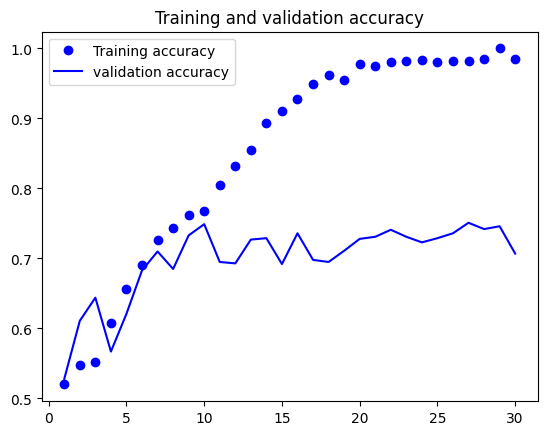

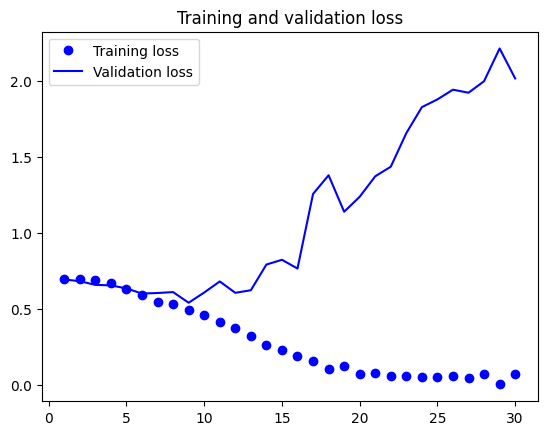

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# 위 그래프는 과대적합의 특성을 보여줍니다. 훈련 정확도가 시간이 지남에 따라 선형적으로 증가해서 거의 100%에 도달합니다. 반면 검증 정확도는 75%가 최고입니다. 검증 손실은 열 번의 에포크만에 최솟값에 다다른 이후 더 이상 진전되지 않았습니다. 반면 훈련 손실은 훈련이 진행됨에 따라 선형적으로 계속 감소합니다.

In [ ]:
# 테스트 세트에서 모델 평가하기

test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도 : {test_acc:.3f}")

63/63 [==============================] - 1s 18ms/step - loss: 0.5537 - accuracy: 0.7285
테스트 정확도 : 0.729


# 비교적 훈련 샘플의 개수(2,000개)가 적기 때문에 과대적합(overfitting)이 가장 중요한 문제입니다. 여기서는 컴퓨터 비전에 특화되어 있어 딥러닝으로 이미지를 다룰 때 매우 일반적으로 사용되는 새로운 방법인 "데이터 증식(Data Augmentation)"을 시도해 보겠습니다.

In [ ]:
# 컨브넷에 추가할 데이터 증식 단계 정의하기
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

- RandomFlip("horizontal") : 랜덤하게 50% 이미지를 수평으로 뒤집습니다.
- RandomRotation(0.1) : [-10%, +10%] 범위 안에서 랜덤한 값만큼 입력 이미지를 회전합니다. (전체 원에 대한 비율입니다. 각도로 나타내면 [-36도, +36도]에 해당합니다. 양수는 반시계방향 회전, 음수는 시계방향 회전을 나타냅니다. 음수와 양수의 범위가 다른 경우 (-0.1, 0.2)와 같이 튜플로 지정할 수 있습니다.)
- RandomZoom(0.2) : [-20%, +20%] 범위 안에서 랜덤한 비율만큼 이미지를 확대 또는 축소합니다.

# 증식된 이미지를 확인해 보겠습니다.

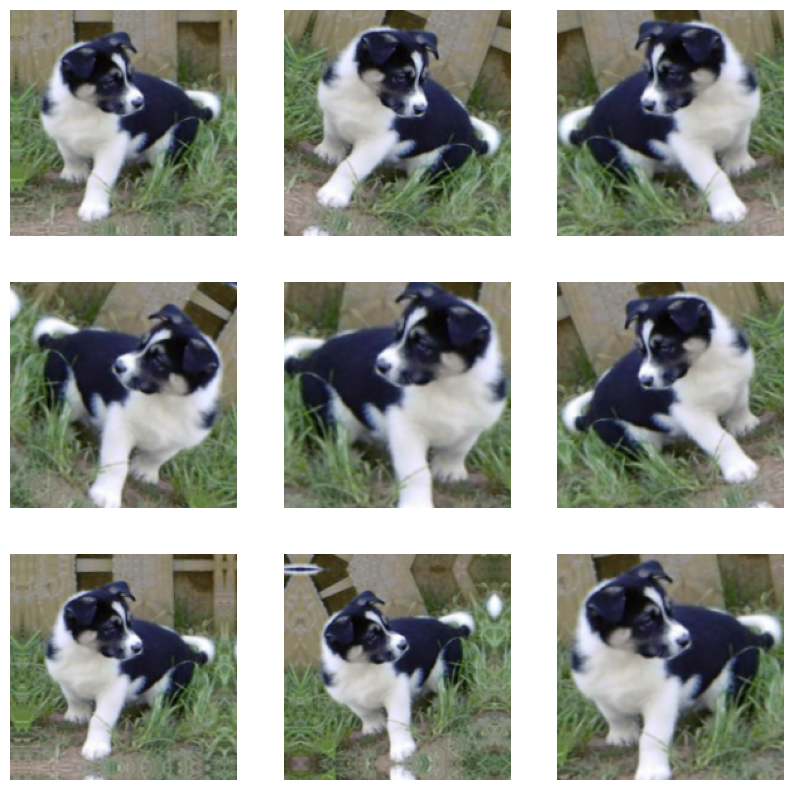

In [ ]:
# 랜덤하게 증식된 훈련 이미지 출력하기

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):  
    # take(n)을 사용하여 데이터셋에서 N개의 배치만 샘플링합니다. 
    # 이는 N번째 배치 후에 루프를 중단하는 것과 같습니다.
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# 이미지 증식과 드롭아웃을 포함한 컨브넷 만들기
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

데이터 증식과 드롭아웃을 사용해서 모델을 훈련해 보겠습니다. 훈련에서 과대적합이 훨씬 늦게 일어날 것으로 기대되기 때문에 3배 많은 100에포크 동안 훈련하겠습니다.

In [ ]:
# 규제를 추가한 컨브넷 훈련하기
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 [==============================] - 5s 37ms/step - loss: 0.6935 - accuracy: 0.5225 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 2s 34ms/step - loss: 0.7008 - accuracy: 0.5275 - val_loss: 0.6907 - val_accuracy: 0.5320
Epoch 3/100
63/63 [==============================] - 2s 36ms/step - loss: 0.6909 - accuracy: 0.5490 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 2s 33ms/step - loss: 0.6845 - accuracy: 0.5720 - val_loss: 0.6598 - val_accuracy: 0.6610
Epoch 5/100
63/63 [==============================] - 3s 39ms/step - loss: 0.6709 - accuracy: 0.6065 - val_loss: 0.6797 - val_accuracy: 0.5470
Epoch 6/100
63/63 [==============================] - 3s 40ms/step - loss: 0.6542 - accuracy: 0.6355 - val_loss: 0.7632 - val_accuracy: 0.5600
Epoch 7/100
63/63 [==============================] - 2s 33ms/step - loss: 0.6458 - accuracy: 0.6315 - val_loss: 0.6411 - val_accuracy: 0.6120
Epoch 

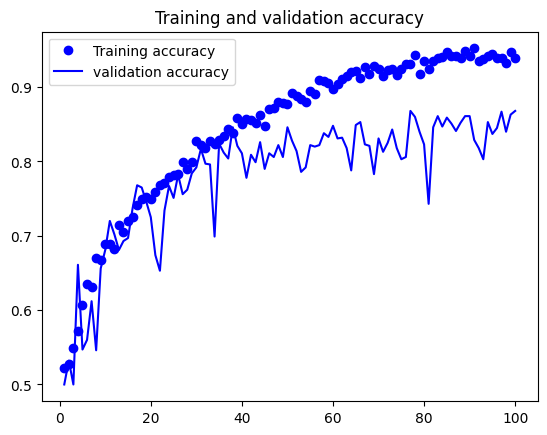

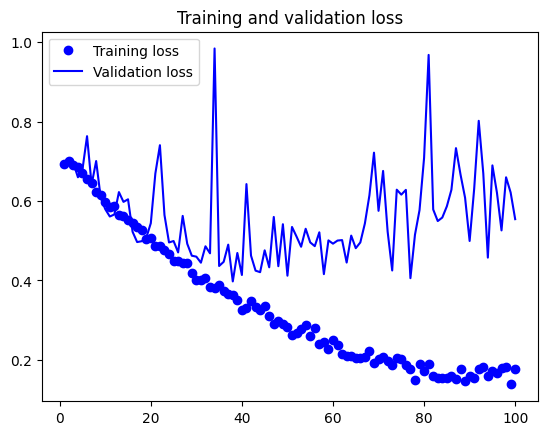

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

데이터 증식과 드롭아웃 덕분에 과대적합이 훨씬 늦은 60\~70번째 에포크 근처에서 시작됩니다.

(원본 모델은 10번째 에포크에서 시작되었습니다.) 

검증 정확도는 80~85% 범위에서 유지됩니다. 이전 모델보다 훨씬 성능이 좋아졌습니다.

# 테스트 세트의 정확도를 확인해 보죠.

In [ ]:
# 테스트 세트에서 모델 훈련하기
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도 : {test_acc:.3f}")

63/63 [==============================] - 1s 18ms/step - loss: 0.4638 - accuracy: 0.8100
테스트 정확도 : 0.810


모델의 파라미터를 튜닝하면(합성곱 층의 필터 개수나 모델에 있는 층의 수 등) 90% 정도까지 더 높은 정확도를 얻을 수도 있습니다. 하지만 데이터가 적기 때문에 컨브넷을 처음부터 훈련해서 더 높은 정확도를 달성하기는 어렵습니다. 이런 상황에서 정확도를 높이기 위한 다음 단계는 사전 훈련된 모델을 사용하는 것입니다. 이에 대해 집중적으로 살펴보겠습니다.

In [ ]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

58889256/58889256 [==============================] - 0s 0us/step


VGG16은 합성곱 층 13개, 밀집연결(Dense)층 3개로 이루어진 모델입니다.

케라스에서 제공하는 사전 훈련된 모델의 전체 목록은 공식 문서(https://keras.io/api/applications/)를 참고하세요.

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

최종 특성 맵의 크기는 (5, 5, 512)입니다. 이 특성 위에 밀집 연결 층을 놓을 것입니다.

이 지점에서 두 가지 방식이 가능합니다.

- 새로운 데이터셋에서 합성곱 기반 층을 실행하고 출력을 넘파이 배열로 디스크에 저장합니다. 그 다음 이 데이터를 독립된 밀집연결 분류기(Dense층으로만 만들어진 모델)에 입력으로 사용하는 방법입니다. 합성곱 연산은 전체 과정 중에서 가장 비용이 큰 부분입니다. 그래서 이 방식을 사용하면 모든 입력 이미지에 대해 합성곱 기반 층을 한 번만 실행하면 되기 때문에 빠르고 계산비용이 적게 듭니다. 하지만 이런 이유 때문에 이 기법에는 데이터 증식을 사용할 수 없습니다.

- 준비한 모델(conv_base) 위에 Dense층을 쌓아 확장합니다. 그 다음 입력 데이터에서 엔드-투-엔드로 전체 모델을 실행합니다. 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과하기 때문에 데이터 증식을 사용할 수는 있습니다. 하지만 이런 이유로 이 방식은 첫 번째 방식보다 훨씬 (계산)비용이 많이 듭니다.

# 1. 데이터 증식을 사용하지 않는 빠른 특성 추출


In [ ]:
# VGG16 특성과 해당 레이블 추출하기
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)  # <- 아래에서 설명
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)


train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 25ms/step


# vgg16.preprocess_input 함수에 대해

VGG모델은 카페(Caffe)라는 딥러닝 라이브러리에서 훈련되어 정규화 방식이 조금 다릅니다. 입력 데이터의 이미지 채널을 RGB에서 BGR로 바꾸고 ImageNet데이터셋에서 구한 채널별 평균값인 [103.939, 116.779, 123.68]을 뺍니다.

이제 (규제를 위해 드롭아웃을 사용한) 밀집 연결 분류기를 정의하고 방금 저장한 데이터와 레이블에서 훈련할 수 있게 되었습니다.

In [ ]:
# 밀집 연결 분류기 정의하고 훈련하기
inputs = keras.Input(shape=(5,5,512))
x = layers.Flatten()(inputs)  # Dense층에 특성을 주입하기 전에 Flatten 층을 사용합니다.
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 20.4693 - accuracy: 0.9200 - val_loss: 15.4185 - val_accuracy: 0.9250
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 3.2483 - accuracy: 0.9760 - val_loss: 6.3906 - val_accuracy: 0.9620
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 2.0294 - accuracy: 0.9850 - val_loss: 4.3023 - val_accuracy: 0.9750
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 2.2882 - accuracy: 0.9900 - val_loss: 5.1288 - val_accuracy: 0.9750
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 0.4569 - accuracy: 0.9940 - val_loss: 6.3705 - val_accuracy: 0.9680
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 1.5680 - accuracy: 0.9905 - val_loss: 6.3638 - val_accuracy: 0.9620
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.4101 - accuracy: 0.9955 - val_loss: 4.8755 - val_accuracy: 0.9740
Epoch 8/20
63/63 [

2개의 Dense층만 처리하면 되므로 훈련이 매우 빠릅니다. (CPU를 사용하더라도 한 에포크에 걸리는 시간이 1초 미만입니다.)

훈련 과정의 손실과 정확도를 그래프로 나타내보겠습니다.

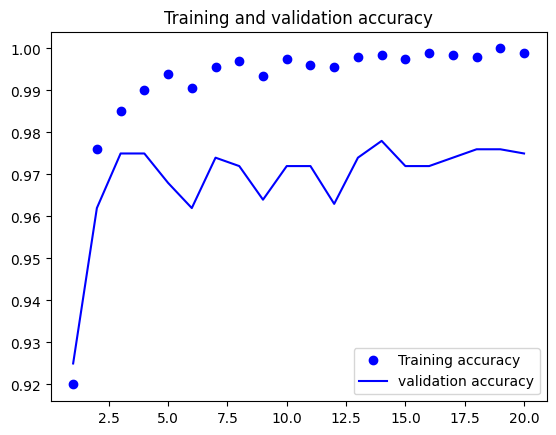

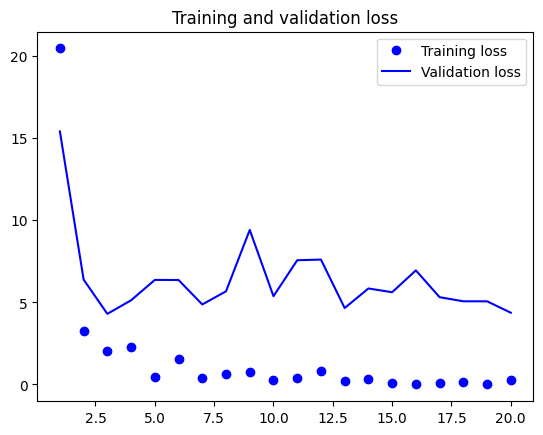

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

이력을 보면 약 97%의 검증 정확도에 도달했습니다. 위 코드에서 처음부터 훈련시킨 작은 모델에서 얻은 것보다 훨씬 좋습니다. 하지만 ImageNet에서 개와 고양이 샘플이 많이 때문에 약간 공정하지 않은 비교입니다. 다시 말하면 사전 훈련된 모델이 현재 주어진 작업에 딱 맞는 지식을 이미 가지고 있습니다. 사전 훈련된 특성을 사용할 때 항상 이렇지는 않습니다.

하지만 이 그래프는 많은 비율로 드롭아웃을 사용했음에도 훈련을 시작하면서 거의 바로 과대적합되고 있다는 것을 보여줍니다. 작은 이미지 데이터셋에서는 과대적합을 막기 위해 필수적인 데이터 증식을 사용하지 않았기 때문입니다.

# 2. 데이터 증식을 사용한 특성 추출

이 방법은 훨씬 느리고 비용이 많이 들지만 훈련하는 동안 데이터 증식 기법을 사용할 수 있습니다. conv_base와 새로운 밀집 분류기를 연결한 모델을 만들고 입력 데이터를 사용하여 엔드-투-엔드로  실행합니다.

이렇게 하려면 먼저 **합성곱 기반 층을 동결(freeze)**해야 합니다. 하나 이상의 층을 동결한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻입니다. 이렇게 하지 않으면 (훈련하는 동안) 사전에 합성곱 기반 층에 의해 학습된 표현이 수정되어버릴 것입니다. 맨 위의 Dense층은 랜덤하게 초기화되었기 때문에 매우 큰 가중치 업데이트 값이 네트워크에 전파되어버립니다. 그리고 이는 사전에 학습된 표현을 크게 훼손하게 됩니다.

케라스에서는 trainable 속성을 False로 설정하여 층이나 모델을 동결할 수 있습니다.

In [ ]:
# VGG16 합성곱 기반 층을 만들고 동결하기
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [ ]:
# 동결하기 전과 후의 훈련 가능한 가중치 리스트 출력하기
conv_base.trainable = True
print("합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수 : ", len(conv_base.trainable_weights))
conv_base.trainable = False
print("합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수 : ", len(conv_base.trainable_weights))

합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수 :  26
합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수 :  0


이제 다음을 연결하여 새로운 모델을 만들 수 있습니다.

1. 데이터 증식 단계

2. 동결된 합성곱 기반 층

3. 밀집 분류기

In [ ]:
# 데이터 증식 단계와 밀집 분류기를 합성곱 기반 층에 추가하기
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)  # 데이터 증식 적용
x = keras.applications.vgg16.preprocess_input(x)  # 입력 값의 스케일 조정
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

이렇게 설정하면 추가한 2개의 Dense층 가중치만 훈련될 것입니다. 층마다 2개씩(가중치 행렬과 편향 벡터) 총 4개의 텐서가 훈련됩니다. 변경 사항을 적용하려면 먼저 모델을 컴파일해야 합니다. 컴파일 단계 후에 trainable 속성을 변경하면 반드시 모델을 다시 컴파일해야 합니다. 그렇지 않으면 변경 사항이 적용되지 않습니다.

모델을 훈련해봅시다. 데이터 증식 덕분에 과대적합이 시작되기까지 훨씬 오래 걸릴 것입니다. 따라서 더 많은 에포크 동안 훈련할 수 있습니다. 50번의 에포크를 시도해 보죠.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 5s 59ms/step - loss: 19.4117 - accuracy: 0.9010 - val_loss: 4.8025 - val_accuracy: 0.9630
Epoch 2/50
63/63 [==============================] - 4s 56ms/step - loss: 7.1211 - accuracy: 0.9485 - val_loss: 2.8786 - val_accuracy: 0.9750
Epoch 3/50
63/63 [==============================] - 4s 54ms/step - loss: 6.8321 - accuracy: 0.9520 - val_loss: 3.0076 - val_accuracy: 0.9780
Epoch 4/50
63/63 [==============================] - 4s 55ms/step - loss: 6.0218 - accuracy: 0.9595 - val_loss: 4.1931 - val_accuracy: 0.9760
Epoch 5/50
63/63 [==============================] - 4s 54ms/step - loss: 4.6264 - accuracy: 0.9635 - val_loss: 10.7289 - val_accuracy: 0.9550
Epoch 6/50
63/63 [==============================] - 3s 53ms/step - loss: 4.1648 - accuracy: 0.9680 - val_loss: 4.8469 - val_accuracy: 0.9700
Epoch 7/50
63/63 [==============================] - 4s 60ms/step - loss: 2.7834 - accuracy: 0.9695 - val_loss: 2.4820 - val_accuracy: 0.9800
Epoch 8/50


결과를 다시 그래프로 나타내 보겠습니다. 아래에서 볼 수 있듯이 검증 정확도가 98%에 도달했습니다. 이전 모델보다 크게 향상되었습니다.

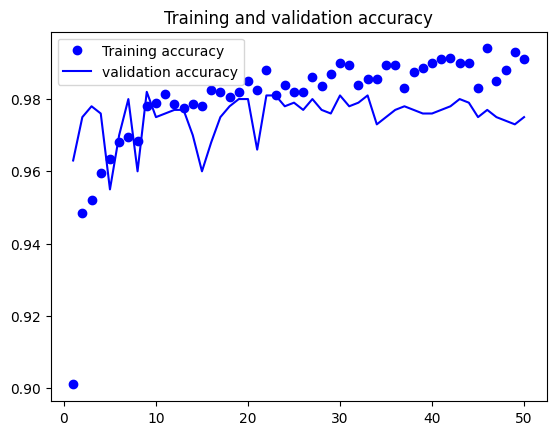

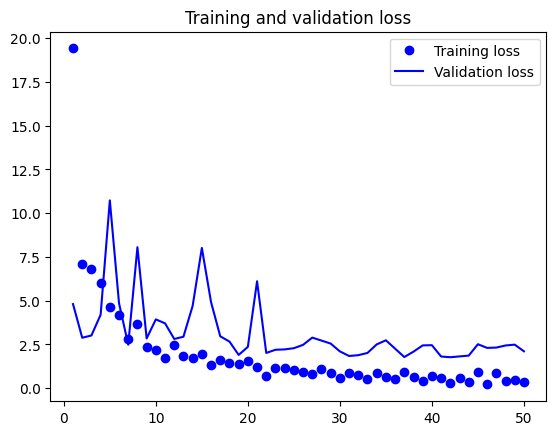

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# 테스트 세트에서 모델 평가하기
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 2s 33ms/step - loss: 2.0181 - accuracy: 0.9800
테스트 정확도: 0.980


테스트 정확도 98.0%를 얻었습니다. 이전에 얻은 테스트 정확도에 비해 조금만 향상된 것으로 검증 데이터의 좋은 결과를 감안할 때 약간 실망스럽기도 합니다. (데이터 증식을 사용하지 않는 특성 추출의 경우에도 97% 이상의 정확도를 얻을 수 있었으니까요.) 모델의 정확도는 항상 평가하려는 샘플 세트에 따라 달라집니다. 일부 샘플 세트는 다른 세트에 비해 어려울 수 있으며, 한 세트에서 좋은 결과가 나왔다고 해서 다른 모든 세트에서도 항상 그런 것은 아닙니다.

# 사전 훈련된(pre-trained) 모델 미세조정(fine-tuning)하기

모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세조정입니다. 미세조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 밀집연결 분류기)과 함께 훈련하는 것입니다. 주어진 문제에 조금 더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 미세 조정이라고 부릅니다.

네트워크를 미세 조정하는 단계는 아래와 같습니다.

1.  사전에 훈련된 기반네트워크 위에 새로운 네트워크 추가(완료)

2. 기반 네트워크 동결(완료)

3. 새로 추가한 네트워크 훈련(완료)

4. 기반 네트워크에서 일부 층의 동결 해제

5. 동결해제한 층과 새로 추가한 층을 함께 훈련

처음 세 단계는 특성 추출을 할 때 이미 완료했습니다. 네 번째 단계부터 진행해보겠습니다. conv_base의 동결을 해제하고 개별 층을 동결하겠습니다.

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

아래 마지막 3개의 합성곱 층을 미세 조정하겠습니다. 즉 block4_pool까지 모든 층을 동결되고, block5_conv1, block5_conv2, block5_conv3층은 학습 대상이 됩니다.

왜 더 많은 층을 미세 조정하지 않을까요? 왜 아예 전체 합성곱 기반 층을 전부 미세조정하면 좋지 않을까요? 가능한 방법이지만, 아래 두 가지 사항을 고려해야 합니다.

- 합성곱 기반 층에 있는 하위(초반) 층들은 좀 더 일반적이고 재사용 가능한 특성들을 인코딩합니다. 반면 상위(후반) 층은 좀 더 특화된 특성을 인코딩합니다. 새로운 문제에 재활용하도록 수정이 필요한 것은 구체적인 특성이므로 이들을 미세조정하는 것이 유리합니다. 하위 층으로 갈수록 미세 조정에 대한 효과가 감소합니다.

- 훈련해야 할 파라미터가 많을수록 과대적합의 위험이 커집니다. 합성곱 기반 층은 1,500만개의 파라미터를 가지고 있습니다. 작은 데이터셋으로 전부 훈련하려고 하면 매우 위험합니다.

그러므로 이런 상황에서는 합성곱 기반 층에서 최상위 2~3개의 층만 미세 조정하는 것이 좋습니다. 앞선 예제 코드에 이어 미세조정을 완료해보겠습니다.

In [ ]:
# 마지막에서 네 번째 층까지 모든 층 동결하기
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

이제 이 모델의 미세조정을 시작하겠습니다. 학습률을 낮춘 RMSProp 옵티마이저를 사용합니다. 학습률을 낮추는 이유는 미세 조정하는 3개의 층에서 학습된 표현을 조금씩만 수정하기 위해서입니다. 변경량이 너무 크면 학습된 표현에 나쁜 영향을 끼칠 수 있습니다.

In [ ]:
# 모델 미세 조정하기
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 6s 64ms/step - loss: 0.0355 - accuracy: 0.9985 - val_loss: 1.2233 - val_accuracy: 0.9790
Epoch 2/30
63/63 [==============================] - 4s 59ms/step - loss: 0.1404 - accuracy: 0.9920 - val_loss: 1.4475 - val_accuracy: 0.9770
Epoch 3/30
63/63 [==============================] - 4s 60ms/step - loss: 0.0930 - accuracy: 0.9945 - val_loss: 1.2209 - val_accuracy: 0.9790
Epoch 4/30
63/63 [==============================] - 4s 60ms/step - loss: 0.1606 - accuracy: 0.9930 - val_loss: 1.1812 - val_accuracy: 0.9820
Epoch 5/30
63/63 [==============================] - 4s 58ms/step - loss: 0.0991 - accuracy: 0.9955 - val_loss: 1.3145 - val_accuracy: 0.9820
Epoch 6/30
63/63 [==============================] - 4s 56ms/step - loss: 0.0756 - accuracy: 0.9950 - val_loss: 1.6219 - val_accuracy: 0.9790
Epoch 7/30
63/63 [==============================] - 4s 56ms/step - loss: 0.1457 - accuracy: 0.9955 - val_loss: 1.4412 - val_accuracy: 0.9820
Epoch 8/30
63

이제 마지막으로 테스트 데이터에서 이 모델을 평가하겠습니다.

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 2s 32ms/step - loss: 1.3843 - accuracy: 0.9810
테스트 정확도: 0.981


평균 98.5% 정도의 테스트 정확도를 얻을 것입니다. (1퍼센트 포인트 정도 차이 날 수 있습니다.) 이 데이터셋을 사용한 원래 캐글 경연대회의 최상위 결과 중 하나에 해당합니다. 하지만 강아지와 고양이에 대한 사전 지식이 이미 포함되어 있는 사전훈련된 특성을 사용했기 때문에 공정한 비교는 아닙니다. 그 당시 대회 참가자들은 이를 사용할 수 없었습니다.

긍정적으로만 보면 최신 딥러닝 기법을 활용하여 대회에서 제공하는 훈련 데이터의 일부분(약 10%)만 사용해서 이런 결과를 달성했습니다. 2만 개의 샘플에서 훈련하는 것과, 2,000개의 샘플에서 훈련하는 것 사이에는 아주 큰 차이가 있습니다.

이제 이미지 분류 문제, 특히 작은 데이터셋을 다루기 위해 필요한 일련의 도구를 확실하게 익혔습니다.

# 요약

- 컨브넷은 컴퓨터 비전 작업에 가장 뛰어난 머신 러닝 모델입니다. 아주 작은 데이터셋에서도 처음부터 훈련해서 괜찮은 성능을 낼 수 있습니다.

- 컨브넷은 시각적 세상을 표현하기 위한 패턴과 개념의 계층 구조를 학습합니다.

- 작은 데이터셋에서는 과대적합이 큰 문제입니다. 데이터 증식은 이미지 데이터를 다룰 때 과대적합을 막을 수 있는 강력한 방법입니다.

- 특성 추출 방식으로 새로운 데이터셋에 기존 컨브넷을 쉽게 재사용할 수 있습니다. 작은 이미지 데이터셋으로 작업할 때 효과적인 기법입니다.

- 특성 추출을 보완하기 위해 미세 조정을 사용할 수 있습니다. 미세 조정은 기존 모델에서 사전에 학습한 표현의 일부를 새로운 문제에 적응시킵니다. 이 기법은 조금 더 성능을 끌어올립니다.